In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

Изображение загружено: (594, 787)
Диапазон значений: 0 - 255


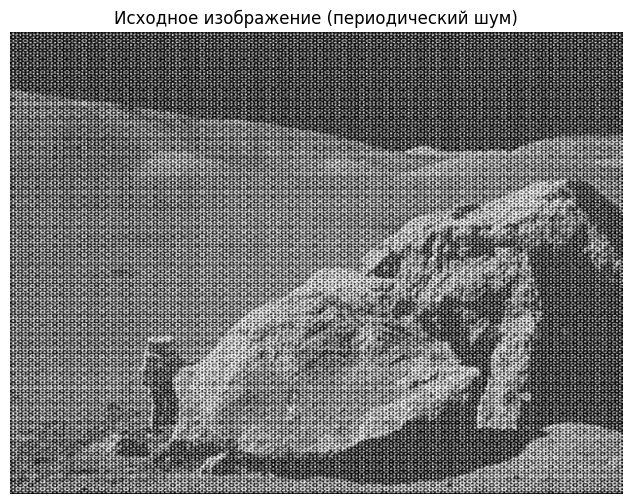

In [2]:
image_filename = 'periodic_noise.jpg'
source_image = cv.imread(image_filename, cv.IMREAD_GRAYSCALE)

if source_image is None:
    raise FileNotFoundError(f"Изображение '{image_filename}' не найдено")

print(f"Изображение загружено: {source_image.shape}")
print(f"Диапазон значений: {source_image.min()} - {source_image.max()}")

# Отображение исходного изображения
plt.figure(figsize=(8, 6))
plt.imshow(source_image, cmap='gray')
plt.title('Исходное изображение (периодический шум)')
plt.axis('off')
plt.show()

In [3]:
fourier_transform = cv.dft(np.float32(source_image), flags=cv.DFT_COMPLEX_OUTPUT)
shifted_dft = np.fft.fftshift(fourier_transform)

# Вычисление амплитудного спектра
amplitude_spectrum = 20 * np.log(cv.magnitude(shifted_dft[:,:,0],
                                               shifted_dft[:,:,1]) + 1e-10)

# Определение параметров изображения
image_rows, image_cols = source_image.shape
center_row, center_col = image_rows // 2, image_cols // 2

In [4]:
cutoff_frequency = 40

# Создание координатных сеток
u_coords = np.arange(image_rows) - center_row
v_coords = np.arange(image_cols) - center_col
V_grid, U_grid = np.meshgrid(v_coords, u_coords)
distance_squared = U_grid**2 + V_grid**2

# Вычисление фильтров Гаусса
gauss_lowpass = np.exp(-distance_squared / (2 * (cutoff_frequency**2)))
gauss_highpass = 1 - gauss_lowpass

# Подготовка фильтра для комплексного спектра
gauss_hp_filter = np.zeros((image_rows, image_cols, 2), dtype=np.float32)
gauss_hp_filter[:, :, 0] = gauss_highpass
gauss_hp_filter[:, :, 1] = gauss_highpass

In [5]:
filtered_dft_hp = shifted_dft * gauss_hp_filter

# Обратное преобразование
inverse_shift_hp = np.fft.ifftshift(filtered_dft_hp)
restored_image_hp = cv.idft(inverse_shift_hp)
restored_image_hp = cv.magnitude(restored_image_hp[:, :, 0],
                                 restored_image_hp[:, :, 1])

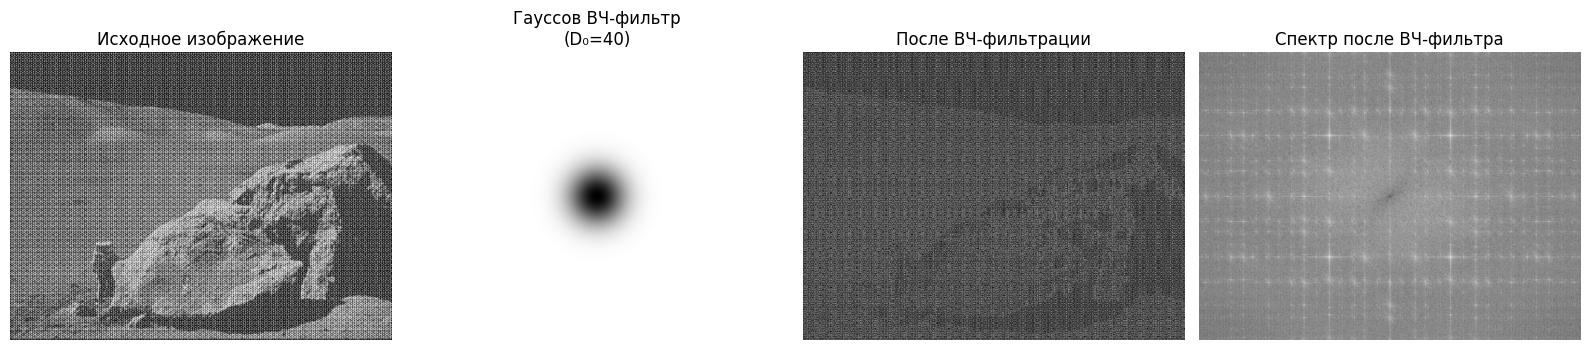

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].imshow(source_image, cmap='gray')
axes[0].set_title('Исходное изображение')
axes[0].axis('off')

axes[1].imshow(gauss_highpass, cmap='gray')
axes[1].set_title(f'Гауссов ВЧ-фильтр\n(D₀={cutoff_frequency})')
axes[1].axis('off')

axes[2].imshow(restored_image_hp, cmap='gray')
axes[2].set_title('После ВЧ-фильтрации')
axes[2].axis('off')

# Амплитудный спектр после фильтрации
filtered_spectrum_hp = 20 * np.log(cv.magnitude(filtered_dft_hp[:, :, 0],
                                                filtered_dft_hp[:, :, 1]) + 1)
axes[3].imshow(filtered_spectrum_hp, cmap='gray')
axes[3].set_title('Спектр после ВЧ-фильтра')
axes[3].axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Пересчитываем преобразование Фурье (для чистоты эксперимента)
fourier_transform = cv.dft(np.float32(source_image), flags=cv.DFT_COMPLEX_OUTPUT)
shifted_dft = np.fft.fftshift(fourier_transform)

# Амплитудный спектр
amplitude_spectrum = 20 * np.log(cv.magnitude(shifted_dft[:,:,0],
                                               shifted_dft[:,:,1]) + 1)

# Создание координатных массивов
Y_coords, X_coords = np.ogrid[:image_rows, :image_cols]

# Маскирование центра спектра для поиска пиков
center_radius = 20
center_region_mask = (Y_coords - center_row)**2 + (X_coords - center_col)**2 <= center_radius**2

spectrum_without_center = amplitude_spectrum.copy()
spectrum_without_center[center_region_mask] = 0

# Поиск наиболее ярких пиков (источников периодического шума)
number_of_peaks = 2
peak_indices = np.argpartition(spectrum_without_center.flatten(),
                                -number_of_peaks)[-number_of_peaks:]
peak_coordinates = np.column_stack(np.unravel_index(peak_indices,
                                                    spectrum_without_center.shape))

print(f"Найдено пиков в спектре: {len(peak_coordinates)}")
for idx, (y, x) in enumerate(peak_coordinates, 1):
    print(f"Пик {idx}: координаты ({y}, {x}), значение {amplitude_spectrum[y, x]:.1f}")

Найдено пиков в спектре: 2
Пик 1: координаты (297, 570), значение 322.8
Пик 2: координаты (297, 216), значение 322.8


In [8]:
notch_radius = 12
notch_filter = np.ones((image_rows, image_cols, 2), dtype=np.float32)

for y_peak, x_peak in peak_coordinates:
    # Вычисление симметричной точки (относительно центра)
    y_symmetric = 2 * center_row - y_peak
    x_symmetric = 2 * center_col - x_peak

    # Создание круговых масок для пика и его симметричного отражения
    notch_mask = (Y_coords - y_peak)**2 + (X_coords - x_peak)**2 <= notch_radius**2
    notch_sym_mask = (Y_coords - y_symmetric)**2 + (X_coords - x_symmetric)**2 <= notch_radius**2

    # Применение масок к фильтру
    notch_filter[:,:,0][notch_mask | notch_sym_mask] = 0
    notch_filter[:,:,1][notch_mask | notch_sym_mask] = 0

print(f"Создан режекторный фильтр с радиусом {notch_radius} пикселей")

Создан режекторный фильтр с радиусом 12 пикселей


In [9]:
filtered_dft_notch = shifted_dft * notch_filter

# Обратное преобразование
inverse_shift_notch = np.fft.ifftshift(filtered_dft_notch)
restored_image_notch = cv.idft(inverse_shift_notch)
restored_image_notch = cv.magnitude(restored_image_notch[:,:,0],
                                    restored_image_notch[:,:,1])

# Спектр после фильтрации
filtered_spectrum_notch = 20 * np.log(cv.magnitude(filtered_dft_notch[:,:,0],
                                                   filtered_dft_notch[:,:,1]) + 1)

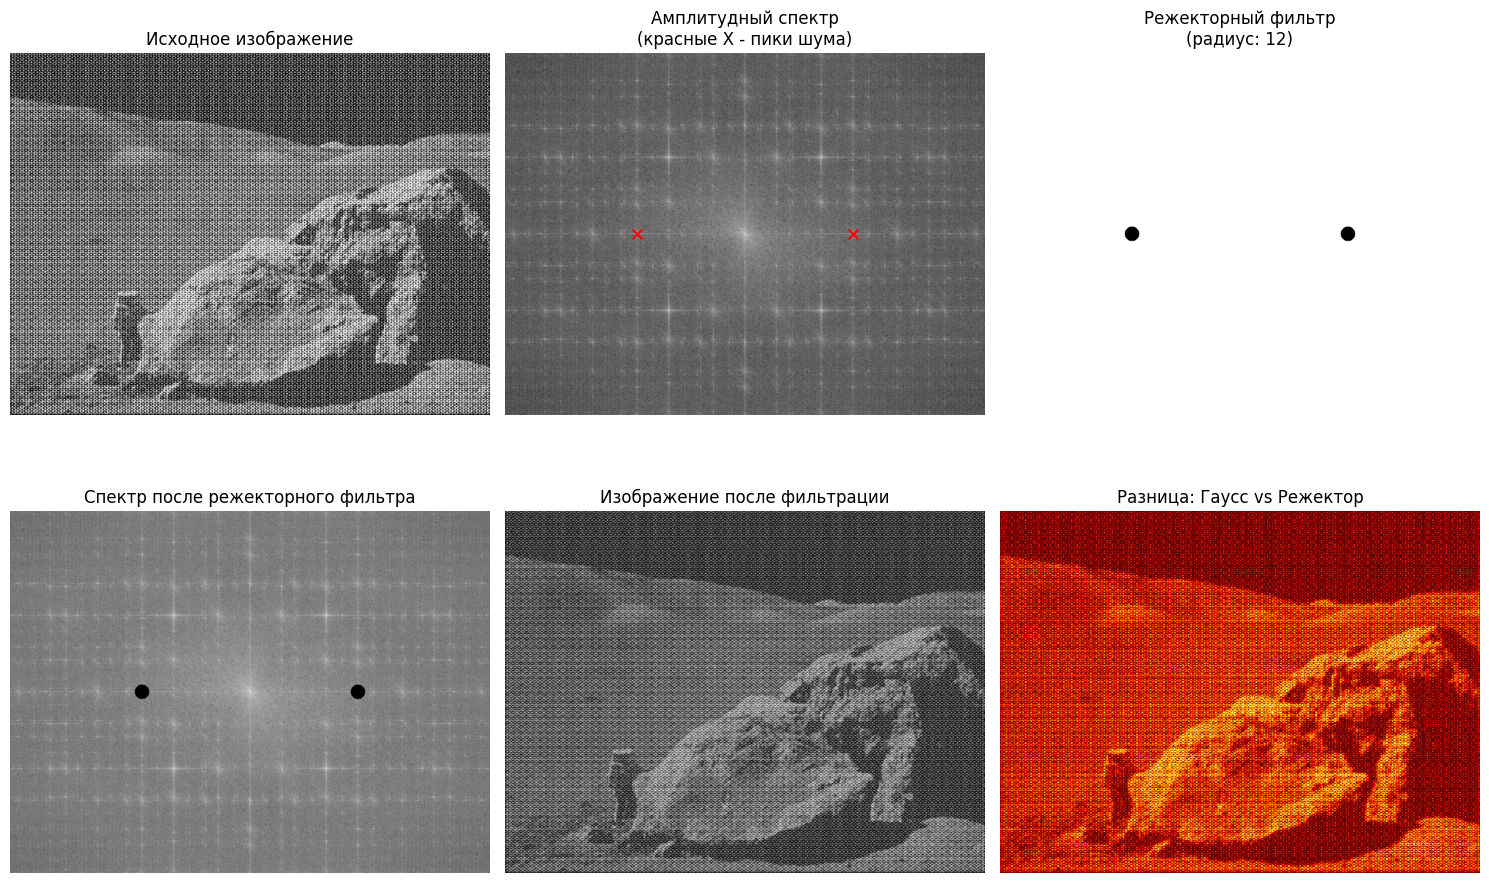

In [10]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Верхний ряд: исходные данные
axes[0, 0].imshow(source_image, cmap='gray')
axes[0, 0].set_title('Исходное изображение')
axes[0, 0].axis('off')

axes[0, 1].imshow(amplitude_spectrum, cmap='gray')
axes[0, 1].scatter(peak_coordinates[:, 1], peak_coordinates[:, 0],
                   c='red', s=50, marker='x')
axes[0, 1].set_title('Амплитудный спектр\n(красные X - пики шума)')
axes[0, 1].axis('off')

axes[0, 2].imshow(notch_filter[:,:,0], cmap='gray')
axes[0, 2].set_title(f'Режекторный фильтр\n(радиус: {notch_radius})')
axes[0, 2].axis('off')

# Нижний ряд: результаты
axes[1, 0].imshow(filtered_spectrum_notch, cmap='gray')
axes[1, 0].set_title('Спектр после режекторного фильтра')
axes[1, 0].axis('off')

axes[1, 1].imshow(restored_image_notch, cmap='gray')
axes[1, 1].set_title('Изображение после фильтрации')
axes[1, 1].axis('off')

# Разница между гауссовым и режекторным фильтрами
if restored_image_hp.shape == restored_image_notch.shape:
    difference = cv.absdiff(restored_image_hp.astype(np.float32),
                            restored_image_notch.astype(np.float32))
    axes[1, 2].imshow(difference, cmap='hot')
    axes[1, 2].set_title('Разница: Гаусс vs Режектор')
    axes[1, 2].axis('off')
else:
    axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

In [11]:
print("=" * 70)
print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ МЕТОДОВ ФИЛЬТРАЦИИ ПЕРИОДИЧЕСКОГО ШУМА")
print("=" * 70)

# Метрики для исходного изображения
orig_mean = np.mean(source_image)
orig_std = np.std(source_image)

# Метрики для гауссова ВЧ-фильтра
gauss_mean = np.mean(restored_image_hp)
gauss_std = np.std(restored_image_hp)

# Метрики для режекторного фильтра
notch_mean = np.mean(restored_image_notch)
notch_std = np.std(restored_image_notch)

print(f"\n1. Исходное изображение:")
print(f"   Среднее: {orig_mean:8.2f} | Стандартное отклонение: {orig_std:8.2f}")

print(f"\n2. Гауссов высокочастотный фильтр (D₀={cutoff_frequency}):")
print(f"   Среднее: {gauss_mean:8.2f} | Стандартное отклонение: {gauss_std:8.2f}")
print(f"   Изменение std: {(gauss_std - orig_std):+.2f} ({100*(gauss_std-orig_std)/orig_std:+.1f}%)")

print(f"\n3. Режекторный фильтр (радиус={notch_radius}):")
print(f"   Среднее: {notch_mean:8.2f} | Стандартное отклонение: {notch_std:8.2f}")
print(f"   Изменение std: {(notch_std - orig_std):+.2f} ({100*(notch_std-orig_std)/orig_std:+.1f}%)")

print(f"\n4. Разница между методами:")
print(f"   Среднее гаусс - среднее режектор: {gauss_mean - notch_mean:.2f}")
print(f"   Std гаусс - Std режектор: {gauss_std - notch_std:.2f}")

print("=" * 70)

СРАВНИТЕЛЬНЫЙ АНАЛИЗ МЕТОДОВ ФИЛЬТРАЦИИ ПЕРИОДИЧЕСКОГО ШУМА

1. Исходное изображение:
   Среднее:   107.65 | Стандартное отклонение:    74.93

2. Гауссов высокочастотный фильтр (D₀=40):
   Среднее: 26974868.00 | Стандартное отклонение: 16885582.00
   Изменение std: +16885507.07 (+22535279.7%)

3. Режекторный фильтр (радиус=12):
   Среднее: 50892856.00 | Стандартное отклонение: 30352520.00
   Изменение std: +30352445.07 (+40508161.0%)

4. Разница между методами:
   Среднее гаусс - среднее режектор: -23917988.00
   Std гаусс - Std режектор: -13466938.00


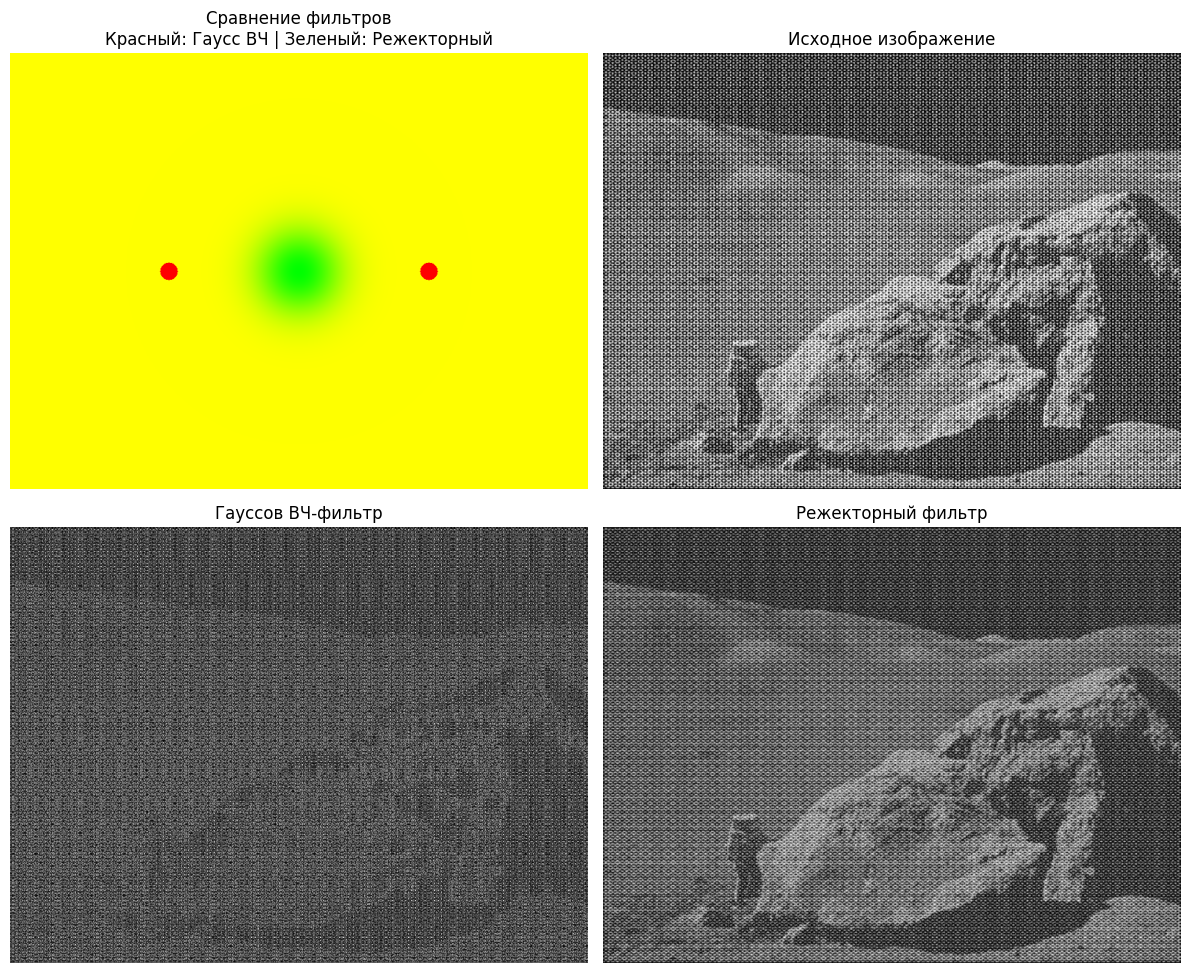

Анализ завершён. Результаты сохранены.


In [12]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Визуализация фильтров
filter_display = np.zeros((image_rows, image_cols, 3), dtype=np.float32)
filter_display[:,:,0] = gauss_highpass  # Гауссов фильтр (красный)
filter_display[:,:,1] = notch_filter[:,:,0]  # Режекторный фильтр (зеленый)
filter_display[:,:,2] = 0  # Синий канал не используется

axes[0, 0].imshow(filter_display)
axes[0, 0].set_title('Сравнение фильтров\nКрасный: Гаусс ВЧ | Зеленый: Режекторный')
axes[0, 0].axis('off')

# Исходное изображение
axes[0, 1].imshow(source_image, cmap='gray')
axes[0, 1].set_title('Исходное изображение')
axes[0, 1].axis('off')

# Результаты фильтрации
axes[1, 0].imshow(restored_image_hp, cmap='gray')
axes[1, 0].set_title('Гауссов ВЧ-фильтр')
axes[1, 0].axis('off')

axes[1, 1].imshow(restored_image_notch, cmap='gray')
axes[1, 1].set_title('Режекторный фильтр')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

print("Анализ завершён. Результаты сохранены.")